In [38]:
import kachaka_api
from IPython.display import Image, clear_output, display

client = kachaka_api.aio.KachakaApiClient("192.168.11.92:26400")

Area=2910.0


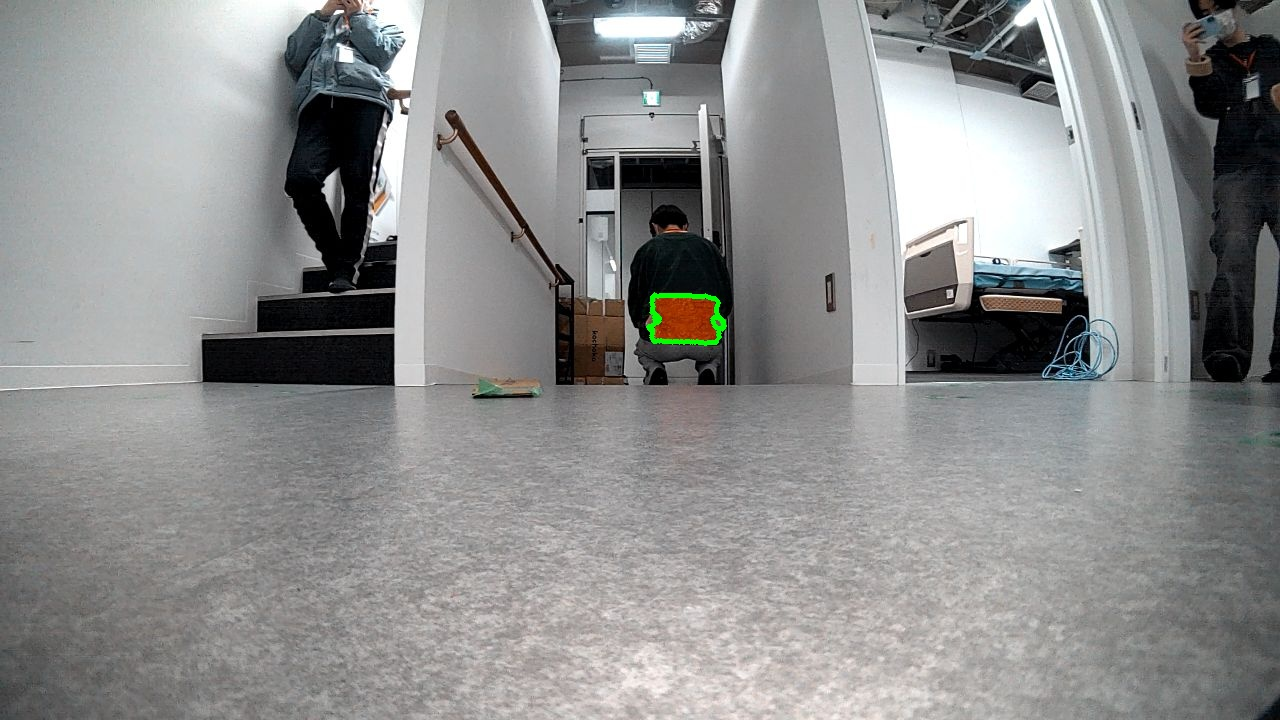

CancelledError: 

In [28]:
import cv2
import numpy as np
import math


bg = None
th = 30

def color_detect(img):
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    hsv_min = np.array([0, 127, 0])
    hsv_max = np.array([12, 255, 255])
    mask1 = cv2.inRange(hsv, hsv_min, hsv_max)
    # hsv_min = np.array([150, 127, 0])
    # hsv_max = np.array([179, 255, 255])
    # mask2 = cv2.inRange(hsv, hsv_min, hsv_max)
    return mask1 #+ mask2

def analysis_blob(binary_img):
    label = cv2.connectedComponentsWithStats(binary_img)
    n = label[0] - 1
    data = np.delete(label[2], 0, 0)
    center = np.delete(label[3], 0, 0)
    max_index = np.argmax(data[:, 4])
    maxblob = {}
    maxblob["upper_left"] = (data[:, 0][max_index], data[:, 1][max_index])
    maxblob["width"] = data[:, 2][max_index]
    maxblob["height"] = data[:, 3][max_index]
    maxblob["area"] = data[:, 4][max_index]
    maxblob["center"] = center[max_index]
    return maxblob


async for image in client.front_camera_ros_compressed_image.stream():
    clear_output(wait=True)
    np_arr = np.frombuffer(image.data, np.uint8)
    frame = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
        
    mask = color_detect(frame)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea) if contours else None
    cv2.drawContours(frame, [contour], -1, (0, 255, 0), 3) if contour is not None else None
    area = cv2.contourArea(contour)
    print("Area=" + str(area))


    target = analysis_blob(mask)

    center_x = int(target["center"][0])
    center_y = int(target["center"][1])

    # cv2.circle(frame, (center_x, center_y), 30, (0, 200, 0),thickness=3, lineType=cv2.LINE_AA)

    _, jpeg_mask = cv2.imencode('.jpg', frame)
    display(Image(data=jpeg_mask.tobytes(), format='jpeg'))
    cv2.imwrite("C:\\Users\\shinma\\Desktop\\python\\final\\image\\frame.jpg", frame)

    center_x-=640
    angle = float((center_x/640)*-90)
    if(abs(angle)>10):
        angle_rad = math.radians(angle)
        await client.rotate_in_place(angle_rad)
    else:
        if(area<6000):
            walk_len = (7000-area)/4000
            await client.move_forward(walk_len,speed=walk_len*2)
    
    


    

In [44]:
client.speak("16時からの塾まで、あと30分だよ。")

<coroutine object KachakaApiClientBase.speak at 0x000001BFB48DBAE0>